Import

In [1]:
import json
import pandas as pd
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from joypy import joyplot
from matplotlib.cm import viridis
import plotly.express as px
import squarify
from numpy import float64
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructField, StringType
from pyspark.sql.functions import monotonically_increasing_id, concat, lit, col 
from tkinter.tix import Tree
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_date, year, month, dayofmonth
from pyspark.sql.functions import mean, min, stddev, count, col, when, mode, median, percentile_approx
from pyspark.sql import functions as F
from numpy import float64, int64

---

In [2]:
spark = SparkSession.builder \
    .appName("LocalApp") \
    .master("local[*]") \
    .getOrCreate()

df_spark = spark.read.csv("E:/Khaithacdulieulon/data/heart_2022_with_nans.csv", header=True, inferSchema=True)
df_spark.show()


+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|Diffi

Create Spark Session and Pull data

---

Add PersonID to easy manage

In [3]:
df_spark = df_spark.withColumn("id", monotonically_increasing_id())
df_spark = df_spark.withColumn("PersonID", concat(lit("Person"), df_spark["id"]))
col_sort = ["PersonID"] + [col for col in df_spark.columns if col != "PersonID"]
df_spark = df_spark.select(col_sort)
df_spark.show()

+--------+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+---+
|PersonID|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|Difficult

---

Remove columns id

In [4]:
df_spark = df_spark.drop("id")
df_spark1 = df_spark
df_spark2 = df_spark

---

Fill nan with max of three func (mean, mode, median) in ["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"] columns

In [5]:
col_convertint = ["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"]
for col_name in col_convertint:
    df_spark1 = df_spark1.withColumn(col_name, col(col_name).cast("float"))

df_spark1.printSchema()
df_spark1.dtypes
col_float = [item[0] for item in df_spark1.dtypes if item[1].startswith('float') and item[0] not in ['year', 'month', 'day']]
for col_name in col_float:
    x = df_spark1.select(mean(col_name)).collect()[0][0]
    y = df_spark1.select(mode(col_name)).collect()[0][0]
    z = df_spark1.select(percentile_approx(col_name, 0.5)).collect()[0][0]
    df_spark1 = df_spark1.na.fill({col_name: max(x, y, z)})

root
 |-- PersonID: string (nullable = false)
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: float (nullable = true)
 |-- MentalHealthDays: float (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: float (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- Difficu

---

Data transformation, if boolean columns convert to 0 | 1, else convert to int

In [6]:
list_string_to_num = ["State", "GeneralHealth", "LastCheckupTime", "RemovedTeeth", "SmokerStatus", "ECigaretteUsage", "RaceEthnicityCategory", "AgeCategory", "TetanusLast10Tdap"]
list_bool_to_num = ['PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos']

for col_name in list_string_to_num:
    dict_mapping = {row[col_name]: j + 1 for j, row in enumerate(df_spark1.select(col_name).dropna(subset=[col_name]).dropDuplicates().orderBy(col_name, ascending=True).collect(), start=0)}
    mapping_expr = F.create_map([F.lit(x) for x in sum(dict_mapping.items(), ())])
    df_spark1 = df_spark1.withColumn(f"{col_name}_mapped", mapping_expr.getItem(F.col(col_name)))

for col_name in list_bool_to_num:
    dict_mapping = {"Yes": 1, "No": 0}
    mapping_expr = F.create_map([F.lit(x) for x in sum(dict_mapping.items(), ())])
    df_spark1 = df_spark1.withColumn(f"{col_name}_mapped", mapping_expr.getItem(F.col(col_name)))

dict_sex_mapping = {"Male": 1, "Female": 0}
mapping_expr = F.create_map([F.lit(x) for x in sum(dict_sex_mapping.items(), ())])
df_spark1 = df_spark1.withColumn(f"Sex_mapped", mapping_expr.getItem(F.col("Sex")))

E:\spark\spark-3.5.6-bin-hadoop3\python\pyspark\sql\column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


---

Get all data columns and start fill nan

In [7]:
df_pyspark = df_spark1.select([col for col in df_spark1.columns if col.endswith('_mapped') or col in col_float or col == 'PersonID'])
df_pyspark.show()

+--------+------------------+----------------+----------+--------------+-----------------+---------+------------+--------------------+----------------------+-------------------+-------------------+----------------------+----------------------------+------------------+------------------------+-------------------------+---------------------+----------------+----------------+----------------+--------------------+--------------+----------------------------+-----------------------+-------------------+------------------+--------------------------+------------------------------+------------------------------+------------------------+--------------------------------+------------------------+----------------+----------------------+-----------------+-------------------+--------------------+-----------------------+---------------+----------+
|PersonID|PhysicalHealthDays|MentalHealthDays|SleepHours|HeightInMeters|WeightInKilograms|      BMI|State_mapped|GeneralHealth_mapped|LastCheckupTime_mapped|

In [8]:
df_test = df_pyspark.select("*").limit(10)
df_test.count()

10

In [9]:
df_test.show()

+--------+------------------+----------------+----------+--------------+-----------------+---------+------------+--------------------+----------------------+-------------------+-------------------+----------------------+----------------------------+------------------+------------------------+-------------------------+---------------------+----------------+----------------+----------------+--------------------+--------------+----------------------------+-----------------------+-------------------+------------------+--------------------------+------------------------------+------------------------------+------------------------+--------------------------------+------------------------+----------------+----------------------+-----------------+-------------------+--------------------+-----------------------+---------------+----------+
|PersonID|PhysicalHealthDays|MentalHealthDays|SleepHours|HeightInMeters|WeightInKilograms|      BMI|State_mapped|GeneralHealth_mapped|LastCheckupTime_mapped|

---

Measuring Data Similarity and Dissimilarity

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array, size, expr

from itertools import combinations

noun_list = ["State_mapped", "Sex_mapped", "LastCheckupTime_mapped", "SmokerStatus_mapped", "ECigaretteUsage_mapped", "RaceEthnicityCategory_mapped", "TetanusLast10Tdap_mapped"]

def noun_cal_spark(list, df_spark):
    df_array = df_spark.withColumn("features", F.array(*[F.col(c) for c in list]))
    p = len(list)
    rows = df_array.select("features").rdd.map(lambda row: row['features']).collect()
    n = len(rows)
    dist_matrix = np.zeros((n, n))
    for i, j in combinations(range(n), 2):
        m = sum([1 if rows[i][k] == rows[j][k] else 0 for k in range(p)])
        d = (p - m) / p
        #dist_matrix[i, j] = d
        dist_matrix[j, i] = round(d, 5)
    return dist_matrix

print(noun_cal_spark(noun_list, df_test))


[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.42857 0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.28571 0.28571 0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.42857 0.28571 0.28571 0.      0.      0.      0.      0.      0.
  0.     ]
 [0.28571 0.14286 0.14286 0.14286 0.      0.      0.      0.      0.
  0.     ]
 [0.42857 0.28571 0.28571 0.28571 0.14286 0.      0.      0.      0.
  0.     ]
 [0.57143 0.42857 0.42857 0.28571 0.28571 0.42857 0.      0.      0.
  0.     ]
 [0.14286 0.28571 0.14286 0.28571 0.14286 0.28571 0.42857 0.      0.
  0.     ]
 [0.14286 0.57143 0.42857 0.42857 0.42857 0.57143 0.42857 0.28571 0.
  0.     ]
 [0.28571 0.14286 0.14286 0.14286 0.      0.14286 0.28571 0.14286 0.42857
  0.     ]]


In [ ]:
from pyspark.sql import functions as F, Window
import numpy as np

def convert_dict_to_01(mapping):
    if not mapping:
        return {}
    var = len(mapping) - 1 if len(mapping) > 1 else 1
    return {k: (v - 1) / var for k, v in mapping.items()}


def ordinal_cal_spark(col_name, df_spark, mapping_01):
    w = Window.orderBy(F.monotonically_increasing_id())
    df_idx = df_spark.withColumn("idx", F.row_number().over(w) - 1)

    map_expr = F.create_map([F.lit(x) for x in sum(mapping_01.items(), ())])
    df_mapped = df_idx.withColumn("_mapped", F.element_at(map_expr, F.col(col_name)).cast("double"))

    df_valid = df_mapped.filter(F.col("_mapped").isNotNull())

    a = df_valid.alias("a")
    b = df_valid.alias("b")
    pairs = (
        a.join(b, F.col("a.idx") > F.col("b.idx"))
         .select(
             F.col("a.idx").alias("i"),
             F.col("b.idx").alias("j"),
             F.abs(F.col("a._mapped") - F.col("b._mapped")).alias("val")
         )
    )

    n = df_mapped.count()
    arr = np.zeros((n, n), dtype=np.float64)

    for row in pairs.collect():
        i, j, val = row["i"], row["j"], row["val"]
        arr[i, j] = val
        arr[j, i] = val  # đối xứng nếu cần

    return np.tril(arr)

 
# import pandas as pd
# dist_df = pd.DataFrame(ordinal_cal_spark("GeneralHealth_mapped", df_test, convert_dict_to_01(dict_ord)))
# print(dist_df)

In [12]:
dict_ord_gen = {i + 1: i + 1 for i in range(5)}
dict_ord_age = {i + 1: i + 1 for i in range(13)}
ordinal_arr1 = ordinal_cal_spark("GeneralHealth_mapped", df_test, convert_dict_to_01(dict_ord_gen))
ordinal_arr2 = ordinal_cal_spark("AgeCategory_mapped", df_test, convert_dict_to_01(dict_ord_age))

arr_ord = (ordinal_arr1 + ordinal_arr2) / 2

print(arr_ord)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5        0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.20833333 0.70833333 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5        0.         0.5        0.         0.         0.
  0.         0.         0.         0.        ]
 [0.70833333 0.45833333 0.5        0.125      0.         0.
  0.         0.         0.         0.        ]
 [0.125      0.375      0.33333333 0.375      0.58333333 0.
  0.         0.         0.         0.        ]
 [0.         0.5        0.20833333 0.5        0.70833333 0.125
  0.         0.         0.         0.        ]
 [0.25       0.25       0.45833333 0.25       0.45833333 0.125
  0.25       0.         0.         0.        ]
 [0.29166667 0.29166667 0.41666667 0.25       0.41666667 0.16666667
  0.29166667 0.04166667 0.         0.        ]
 [0.33333333 0.33333333

In [13]:
from pyspark.sql import Window
from pyspark.sql import functions as F
import numpy as np
from numpy import float64


def num_cal_spark(lst_col_name, df_spark):
    w = Window.orderBy(F.monotonically_increasing_id())
    df_idx = df_spark.withColumn("idx", F.row_number().over(w) - 1)
    n = df_idx.count()
    arr_agg = np.zeros((n, n), dtype=float64)
    
    for col_name in lst_col_name:

        stats = df_idx.agg(F.min(col_name).alias("min"), F.max(col_name).alias("max")).collect()[0]
        min_val = stats["min"]
        max_val = stats["max"]

        if min_val is None or max_val is None or min_val == max_val:
            return np.zeros((n, n), dtype=float64)

        df_norm = df_idx.withColumn(
            "_norm",
            F.when(
                F.col(col_name).isNotNull(),
                (F.col(col_name) - F.lit(min_val)) / F.lit(max_val - min_val)
            ).otherwise(F.lit(None).cast("double"))
        )

        a = df_norm.alias("a")
        b = df_norm.alias("b")
        pairs = (
            a.join(b, F.col("a.idx") > F.col("b.idx"), "inner")
             .select(
                 F.col("a.idx").alias("i"),
                 F.col("b.idx").alias("j"),
                 F.when(
                     F.col("a._norm").isNotNull() & F.col("b._norm").isNotNull(),
                     F.abs(F.col("a._norm") - F.col("b._norm"))
                 ).otherwise(F.lit(0.0)).alias("val")
             )
        )

        data = pairs.collect()
        arr = np.zeros((n, n), dtype=float64)
        for row in data:
            arr[row["i"], row["j"]] = row["val"]
        arr_result = np.tril(arr)
        arr_agg += arr_result
    return arr_agg / len(lst_col_name)

In [14]:
lst_col_num = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
print(num_cal_spark(lst_col_num, df_test))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.30550016 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.74481246 0.4393123  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.32305947 0.17335637 0.52752231 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.62591093 0.48707743 0.46443179 0.38618479 0.         0.
  0.         0.         0.         0.        ]
 [0.27836486 0.35726597 0.60747571 0.35238938 0.57190751 0.
  0.         0.         0.         0.        ]
 [0.33492611 0.18522301 0.53938894 0.01186664 0.37431815 0.36425602
  0.         0.         0.         0.        ]
 [0.14736151 0.15813866 0.59745096 0.20468345 0.47854942 0.3392372
  0.21655009 0.         0.         0.        ]
 [0.08528301 0.22021715 0.65952945 0.32110979 0.70729458 0.28031453
  0.33297643 0.22874516 0.         0.        ]
 [0.19449584 0

In [15]:
from pyspark.sql import Window
from pyspark.sql import functions as F
import numpy as np
from functools import reduce


def boolean_cal_lower_triangle_spark(list_col, df_spark):
    w = Window.orderBy(F.monotonically_increasing_id())
    df_idx = df_spark.select(list_col).withColumn("idx", F.row_number().over(w) - 1)

    a = df_idx.alias("a")
    b = df_idx.alias("b")

    def sum_cols(exprs):
        return reduce(lambda acc, x: acc + x, exprs, F.lit(0)).cast("double")

    q = sum_cols([F.when((F.col(f"a.{c}") == 1) & (F.col(f"b.{c}") == 1), 1).otherwise(0) for c in list_col])
    r = sum_cols([F.when((F.col(f"a.{c}") == 1) & (F.col(f"b.{c}") == 0), 1).otherwise(0) for c in list_col])
    s = sum_cols([F.when((F.col(f"a.{c}") == 0) & (F.col(f"b.{c}") == 1), 1).otherwise(0) for c in list_col])

    denom = q + r + s

    pairs = (
        a.join(b, F.col("a.idx") > F.col("b.idx"), "inner")
         .select(
             F.col("a.idx").alias("i"),
             F.col("b.idx").alias("j"),
             F.when(denom != 0, (r + s) / denom).otherwise(F.lit(0.0)).alias("val")
         )
    )

    n = df_idx.count()
    data = pairs.collect()
    arr = np.zeros((n, n))
    for row in data:
        arr[row["i"], row["j"]] = row["val"]
    return np.round(arr, 2)


In [16]:
list_bool_to_num = ['PhysicalActivities_mapped', 'HadHeartAttack_mapped', 'HadAngina_mapped', 'HadStroke_mapped', 'HadAsthma_mapped', 'HadSkinCancer_mapped', 'HadCOPD_mapped', 'HadDepressiveDisorder_mapped', 'HadKidneyDisease_mapped', 'HadArthritis_mapped', 'HadDiabetes_mapped', 'DeafOrHardOfHearing_mapped', 'BlindOrVisionDifficulty_mapped', 'DifficultyConcentrating_mapped', 'DifficultyWalking_mapped', 'DifficultyDressingBathing_mapped', 'DifficultyErrands_mapped', 'ChestScan_mapped', 'AlcoholDrinkers_mapped', 'HIVTesting_mapped', 'FluVaxLast12_mapped', 'PneumoVaxEver_mapped', 'HighRiskLastYear_mapped', 'CovidPos_mapped']
arr_bool1 = boolean_cal_lower_triangle_spark(list_bool_to_num[:6], df_test)
arr_bool2 = boolean_cal_lower_triangle_spark(list_bool_to_num[6:12], df_test)
arr_bool3 = boolean_cal_lower_triangle_spark(list_bool_to_num[12:18], df_test)
arr_bool4 = boolean_cal_lower_triangle_spark(list_bool_to_num[18:], df_test)
arr_boolean = (arr_bool1 + arr_bool2 + arr_bool3 + arr_bool4) / 4
print(arr_boolean)

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.75   0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.75   0.375  0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.875  1.     0.9175 0.     0.     0.     0.     0.     0.     0.    ]
 [1.     0.75   0.625  0.5425 0.     0.     0.     0.     0.     0.    ]
 [0.5    0.75   0.75   0.875  0.875  0.     0.     0.     0.     0.    ]
 [0.75   0.5    0.375  0.875  0.375  0.75   0.     0.     0.     0.    ]
 [0.625  1.     1.     0.25   0.6675 0.875  1.     0.     0.     0.    ]
 [1.     0.875  0.75   0.6675 0.875  1.     0.875  0.75   0.     0.    ]
 [0.5425 0.75   0.625  0.4575 0.3325 0.5425 0.4175 0.5825 0.875  0.    ]]


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import DenseVector
import numpy as np

spark = SparkSession.builder.getOrCreate()

df_cos = df_pyspark.select(
    ['SmokerStatus_mapped', 'HadHeartAttack_mapped', 'AlcoholDrinkers_mapped', 
     'PhysicalActivities_mapped', 'HeightInMeters']
).dropna().limit(10)  
df_cos.show()
df_vec = df_cos.rdd.zipWithIndex().map(
    lambda x: (x[1], Vectors.dense(x[0]))
).toDF(["idx", "features"])

# Chuẩn hóa vector để tính cosine
normalizer = Normalizer(inputCol="features", outputCol="norm_features", p=2.0)
df_norm = normalizer.transform(df_vec).cache()

# --- Dùng broadcast join để giảm chi phí shuffle ---
df_broadcast = F.broadcast(df_norm.withColumnRenamed("idx", "j").withColumnRenamed("norm_features", "vec_b"))

# --- Tạo cặp (i, j) với i < j ---
df_pairs = (
    df_norm.alias("a")
    .join(df_broadcast.alias("b"), F.col("a.idx") < F.col("b.j"))
    .select("a.idx", "b.j", "a.norm_features", "b.vec_b")
)

@F.udf("double")
def cosine_sim(a, b):
    return float(np.dot(a.toArray(), b.toArray()))

df_result = df_pairs.withColumn("cosine_sim", cosine_sim("norm_features", "vec_b"))

results = df_result.select("idx", "j", "cosine_sim").collect()

n = df_norm.count()
arr_cos_lower = np.zeros((n, n), dtype=float)

for row in results:
    arr_cos_lower[int(row['j']), int(row['idx'])] = row['cosine_sim']

print(arr_cos_lower)


+-------------------+---------------------+----------------------+-------------------------+--------------+
|SmokerStatus_mapped|HadHeartAttack_mapped|AlcoholDrinkers_mapped|PhysicalActivities_mapped|HeightInMeters|
+-------------------+---------------------+----------------------+-------------------------+--------------+
|                  4|                    0|                     0|                        0|     1.7026906|
|                  4|                    0|                     0|                        0|           1.6|
|                  4|                    0|                     0|                        1|          1.57|
|                  2|                    0|                     0|                        1|          1.65|
|                  4|                    0|                     1|                        1|          1.57|
|                  4|                    1|                     0|                        0|           1.8|
|                  3|       

In [ ]:
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import BooleanType
import numpy as np
from numpy import float64


def fill_nan_spark(df_spark, arr_res, col_name):
    w = Window.orderBy(F.monotonically_increasing_id())
    df_idx = df_spark.withColumn("idx", F.row_number().over(w) - 1)

    n = df_idx.count()
    if n == 0:
        return df_spark

    rows = df_idx.select("idx", col_name).orderBy("idx").collect()
    values = [row[col_name] for row in rows]

    target_is_boolean = isinstance(df_spark.schema[col_name].dataType, BooleanType)

    fill_map = {}
    for i in range(n):
        if values[i] is None:
            # tương đồng nhất (nhỏ nhất) trong hàng i
            # Chỉ xét các vị trí j thỏa mãn: j != i, values[j] is not None, arr_res[i, j] != 0
            min_similarity = None
            best_j = None
            
            for j in range(n):
                if j != i and values[j] is not None and arr_res[i, j] != 0:
                    if min_similarity is None or arr_res[i, j] < min_similarity:
                        min_similarity = arr_res[i, j]
                        best_j = j
            
            if best_j is not None:
                v = values[best_j]
                
                if target_is_boolean:
                    if isinstance(v, str):
                        vl = v.lower()
                        if vl == "yes":
                            v = True
                        elif vl == "no":
                            v = False
                        else:
                            v = None
                    else:
                        v = bool(v)
                fill_map[int(i)] = v

    if not fill_map:
        return df_spark

    kvs = []
    for k, v in fill_map.items():
        kvs.extend([F.lit(k), F.lit(v)])
    map_expr = F.create_map(kvs)

    df_filled = df_idx.withColumn(
        col_name,
        F.when(F.col(col_name).isNull(), F.element_at(map_expr, F.col("idx").cast("int"))).otherwise(F.col(col_name))
    ).drop("idx")

    return df_filled

In [ ]:
from pyspark.sql import functions as F, Window
from pyspark.sql import Row
import numpy as np

null_info = df_test.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_test.columns
])
cols_with_null = [
    c for c in null_info.columns if null_info.collect()[0][c] > 0
]

# 1️⃣ Thêm chỉ số hàng vào df_test để ánh xạ ma trận (tuần tự 0, 1, 2, ...)
w = Window.orderBy(F.monotonically_increasing_id())
df_test = df_test.withColumn("row_index", F.row_number().over(w) - 1)
noun_list = ["State_mapped", "Sex_mapped", "LastCheckupTime_mapped", "SmokerStatus_mapped", "ECigaretteUsage_mapped", "RaceEthnicityCategory_mapped", "TetanusLast10Tdap_mapped", "RemovedTeeth_mapped"]
noun_arr = noun_cal_spark(noun_list, df_test)

dict_ord_gen = {i + 1: i + 1 for i in range(5)}
dict_ord_age = {i + 1: i + 1 for i in range(13)}
ordinal_arr1 = ordinal_cal_spark("GeneralHealth_mapped", df_test, convert_dict_to_01(dict_ord_gen))
ordinal_arr2 = ordinal_cal_spark("AgeCategory_mapped", df_test, convert_dict_to_01(dict_ord_age))

lst_col_num = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
num_arr = num_cal_spark(lst_col_num, df_test)

list_bool_to_num = ['PhysicalActivities_mapped', 'HadHeartAttack_mapped', 'HadAngina_mapped', 'HadStroke_mapped', 'HadAsthma_mapped', 'HadSkinCancer_mapped', 'HadCOPD_mapped', 'HadDepressiveDisorder_mapped', 'HadKidneyDisease_mapped']
arr_bool1 = boolean_cal_lower_triangle_spark(list_bool_to_num[:6], df_test)
arr_bool2 = boolean_cal_lower_triangle_spark(list_bool_to_num[6:12], df_test)
arr_bool3 = boolean_cal_lower_triangle_spark(list_bool_to_num[12:18], df_test)
arr_bool4 = boolean_cal_lower_triangle_spark(list_bool_to_num[18:], df_test)
arr_boolean = (arr_bool1 + arr_bool2 + arr_bool3 + arr_bool4) / 4
array_main = np.array(noun_arr + ordinal_arr1 + ordinal_arr2 + num_arr + arr_boolean, dtype=float64) / 5

print(array_main)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.48610003 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.43229583 0.49619579 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.51461189 0.28467127 0.53900446 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.65851552 0.45574882 0.44288636 0.26073696 0.         0.
  0.         0.         0.         0.        ]
 [0.28067297 0.42145319 0.45482848 0.44547788 0.54771483 0.
  0.         0.         0.         0.        ]
 [0.31698522 0.4120446  0.34121112 0.42737333 0.48319696 0.3478512
  0.         0.         0.         0.        ]
 [0.2794723  0.38162773 0.52782352 0.24093669 0.43754322 0.34284744
  0.41831002 0.         0.         0.        ]
 [0.35872327 0.4357101  0.52357256 0.37272196 0.55812558 0.42272957
  0.43326195 0.2624157  0.         0.        ]
 [0.3307325  0

In [ ]:
from pyspark.sql import functions as F, Window
from pyspark.sql import Row
import numpy as np

null_info = df_test.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_test.columns
])
cols_with_null = [
    c for c in null_info.columns if null_info.collect()[0][c] > 0
]

# Thêm chỉ số hàng vào df_test để ánh xạ ma trận (tuần tự 0, 1, 2, ...)
w = Window.orderBy(F.monotonically_increasing_id())
df_test = df_test.withColumn("row_index", F.row_number().over(w) - 1)
noun_list = ["State_mapped", "Sex_mapped", "LastCheckupTime_mapped", "SmokerStatus_mapped", "ECigaretteUsage_mapped", "RaceEthnicityCategory_mapped", "TetanusLast10Tdap_mapped", "RemovedTeeth_mapped"]
noun_arr = noun_cal_spark(noun_list, df_test)

dict_ord_gen = {i + 1: i + 1 for i in range(5)}
dict_ord_age = {i + 1: i + 1 for i in range(13)}
ordinal_arr1 = ordinal_cal_spark("GeneralHealth_mapped", df_test, convert_dict_to_01(dict_ord_gen))
ordinal_arr2 = ordinal_cal_spark("AgeCategory_mapped", df_test, convert_dict_to_01(dict_ord_age))

lst_col_num = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
num_arr = num_cal_spark(lst_col_num, df_test)

list_bool_to_num = ['PhysicalActivities_mapped', 'HadHeartAttack_mapped', 'HadAngina_mapped', 'HadStroke_mapped', 'HadAsthma_mapped', 'HadSkinCancer_mapped', 'HadCOPD_mapped', 'HadDepressiveDisorder_mapped', 'HadKidneyDisease_mapped', 'HadArthritis_mapped', 'HadDiabetes_mapped', 'DeafOrHardOfHearing_mapped', 'BlindOrVisionDifficulty_mapped', 'DifficultyConcentrating_mapped', 'DifficultyWalking_mapped', 'DifficultyDressingBathing_mapped', 'DifficultyErrands_mapped', 'ChestScan_mapped', 'AlcoholDrinkers_mapped', 'HIVTesting_mapped', 'FluVaxLast12_mapped', 'PneumoVaxEver_mapped', 'HighRiskLastYear_mapped', 'CovidPos_mapped']
arr_bool1 = boolean_cal_lower_triangle_spark(list_bool_to_num[:6], df_test)
arr_bool2 = boolean_cal_lower_triangle_spark(list_bool_to_num[6:12], df_test)
arr_bool3 = boolean_cal_lower_triangle_spark(list_bool_to_num[12:18], df_test)
arr_bool4 = boolean_cal_lower_triangle_spark(list_bool_to_num[18:], df_test)
arr_boolean = (arr_bool1 + arr_bool2 + arr_bool3 + arr_bool4) / 4
array_main = np.array(noun_arr + ordinal_arr1 + ordinal_arr2 + num_arr + arr_boolean, dtype=float64) / 5

print(array_main)

# Chuyển ma trận numpy -> DataFrame Spark
n = len(array_main)
array_rows = [
    Row(i=int(i), j=int(j), similarity=float(array_main[i, j]))
    for i in range(n) for j in range(n) if i != j
]
array_main_df = spark.createDataFrame(array_rows)

# Tạo ánh xạ index <-> PersonID
index_map = df_test.select("PersonID", "row_index")

for col in cols_with_null:
    # Các dòng cần điền giá trị
    df_null = df_test.filter(F.col(col).isNull()).select("PersonID", "row_index")

    df_test_values = df_test.select(F.col("PersonID").alias("p2"), F.col("row_index").alias("j"), F.col(col).alias("val_j")).alias("v")
    
    # Tìm trong CỘT (dọc)
    joined_col = (
        df_null.alias("a")
        .join(array_main_df.alias("m"), F.col("a.row_index") == F.col("m.j"))  # Tìm trong cột (m.j == row_index)
        .join(df_test_values, F.col("m.i") == F.col("v.j"))  # Lấy giá trị từ hàng m.i
        .filter(F.col("val_j").isNotNull())
    )

    # Chọn record j có độ tương đồng nhỏ nhất
    window = Window.partitionBy("a.PersonID").orderBy(F.col("similarity").asc())
    best_match = joined_col.withColumn("rn", F.row_number().over(window)).filter("rn = 1")


    filled_df = best_match.select(
        F.col("a.PersonID").alias("PersonID"),
        F.col("val_j").alias(col)
    )

    df_test = (
        df_test.alias("t")
        .join(filled_df.alias("f"), on="PersonID", how="left")
        .withColumn(col, F.coalesce(F.col(f"f.{col}"), F.col(f"t.{col}")))
        .drop("f.*")
    )

df_test = df_test.drop("row_index")
df_test.show()


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.48610003 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.43229583 0.49619579 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.51461189 0.28467127 0.53900446 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.65851552 0.45574882 0.44288636 0.26073696 0.         0.
  0.         0.         0.         0.        ]
 [0.28067297 0.42145319 0.45482848 0.44547788 0.54771483 0.
  0.         0.         0.         0.        ]
 [0.31698522 0.4120446  0.34121112 0.42737333 0.48319696 0.3478512
  0.         0.         0.         0.        ]
 [0.2794723  0.38162773 0.52782352 0.24093669 0.43754322 0.34284744
  0.41831002 0.         0.         0.        ]
 [0.35872327 0.4357101  0.52357256 0.37272196 0.55812558 0.42272957
  0.43326195 0.2624157  0.         0.        ]
 [0.3307325  0

Py4JJavaError: An error occurred while calling o5630.showString.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.catalyst.expressions.AttributeReference.withExprId(namedExpressions.scala:340)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$normalizeExpressions$1.applyOrElse(QueryPlan.scala:665)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$normalizeExpressions$1.applyOrElse(QueryPlan.scala:651)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformUpWithPruning$2(TreeNode.scala:515)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$Lambda$1393/0x0000000100b8c440.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformUpWithPruning(TreeNode.scala:515)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformUp(TreeNode.scala:488)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$.normalizeExpressions(QueryPlan.scala:651)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$doCanonicalize$2(QueryPlan.scala:602)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$Lambda$3513/0x0000000101551840.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$1(QueryPlan.scala:210)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$Lambda$1334/0x0000000100b52440.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpression$1(QueryPlan.scala:210)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.recursiveTransform$1(QueryPlan.scala:221)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$3(QueryPlan.scala:226)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$Lambda$1333/0x0000000100b52840.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.TraversableLike$$Lambda$144/0x00000001002b5040.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.recursiveTransform$1(QueryPlan.scala:226)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$4(QueryPlan.scala:231)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$Lambda$1332/0x0000000100b51840.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.mapExpressions(QueryPlan.scala:231)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.doCanonicalize(QueryPlan.scala:587)


In [24]:
D_temp = df_pyspark.select(['PhysicalActivities_mapped', 'HadHeartAttack_mapped', 'HadAngina_mapped', 'HadStroke_mapped', 'HadAsthma_mapped', 'HadSkinCancer_mapped', 'HadCOPD_mapped', 'HadDepressiveDisorder_mapped']).dropna().limit(50)
D_temp.show()

+-------------------------+---------------------+----------------+----------------+----------------+--------------------+--------------+----------------------------+
|PhysicalActivities_mapped|HadHeartAttack_mapped|HadAngina_mapped|HadStroke_mapped|HadAsthma_mapped|HadSkinCancer_mapped|HadCOPD_mapped|HadDepressiveDisorder_mapped|
+-------------------------+---------------------+----------------+----------------+----------------+--------------------+--------------+----------------------------+
|                        0|                    0|               0|               0|               0|                   0|             0|                           0|
|                        0|                    0|               0|               0|               0|                   1|             0|                           0|
|                        1|                    0|               0|               0|               0|                   1|             0|                           0|
|   

In [ ]:
from itertools import combinations
from pyspark.sql import functions as F

def generate_apriori_spark(df, min_sup):
    cols = df.columns
    level = 2
    all_frequents = {}

    while True:
        frequent = {}
        for comb in combinations(cols, level):
            # Điều kiện: tất cả cột trong comb phải = 1
            condition = [F.col(c) == 1 for c in comb]
            # Kết hợp tất cả điều kiện bằng AND
            combined = condition[0]
            for cond in condition[1:]:
                combined = combined & cond
            
            count = df.filter(combined).count()
            
            if count >= min_sup:
                frequent[comb] = count

        if not frequent:
            break

        all_frequents[level] = frequent
        level += 1

    return all_frequents


In [10]:
min_sup = 2
result = generate_apriori_spark(D_temp, min_sup)
freq_result = None
for level, freq in result.items():
    print(f"Level {level}: {freq}")
    freq_result = freq

Level 2: {('PhysicalActivities_mapped', 'HadHeartAttack_mapped'): 6, ('PhysicalActivities_mapped', 'HadAngina_mapped'): 6, ('PhysicalActivities_mapped', 'HadStroke_mapped'): 4, ('PhysicalActivities_mapped', 'HadAsthma_mapped'): 2, ('PhysicalActivities_mapped', 'HadSkinCancer_mapped'): 10, ('PhysicalActivities_mapped', 'HadCOPD_mapped'): 2, ('PhysicalActivities_mapped', 'HadDepressiveDisorder_mapped'): 4, ('HadHeartAttack_mapped', 'HadAngina_mapped'): 5, ('HadHeartAttack_mapped', 'HadStroke_mapped'): 3, ('HadHeartAttack_mapped', 'HadDepressiveDisorder_mapped'): 4, ('HadAngina_mapped', 'HadStroke_mapped'): 2, ('HadAngina_mapped', 'HadSkinCancer_mapped'): 2, ('HadAngina_mapped', 'HadCOPD_mapped'): 3, ('HadAngina_mapped', 'HadDepressiveDisorder_mapped'): 3, ('HadStroke_mapped', 'HadDepressiveDisorder_mapped'): 2, ('HadAsthma_mapped', 'HadCOPD_mapped'): 2, ('HadSkinCancer_mapped', 'HadCOPD_mapped'): 2, ('HadSkinCancer_mapped', 'HadDepressiveDisorder_mapped'): 2, ('HadCOPD_mapped', 'HadDepre

In [ ]:
from itertools import combinations
from functools import reduce


def count_support(df, cols):
    cond = [F.col(c) == 1 for c in cols]
    return df.filter(reduce(lambda a, b: a & b, cond)).count()

def generate_confidence_rules(df, frequent_dict):
    rules = []
    for itemset, sup_AB in frequent_dict.items():
        # Sinh tất cả các tập con không rỗng và không bằng toàn bộ itemset
        for r in range(1, len(itemset)):
            for A in combinations(itemset, r):
                B = tuple(sorted(set(itemset) - set(A)))
                if not B:  
                    continue
                
                sup_A = count_support(df, A)
                conf = sup_AB / sup_A if sup_A > 0 else 0
                
                rules.append({
                    "A": A,
                    "B": B,
                    "support_AB": sup_AB,
                    "support_A": sup_A,
                    "confidence": conf
                })
    return rules


In [17]:
rules = generate_confidence_rules(D_temp, freq_result)
for r in rules:
    print(f"{r['A']} -> {r['B']} = {r['confidence']:.2f}")

('PhysicalActivities_mapped',) -> ('HadAngina_mapped', 'HadDepressiveDisorder_mapped', 'HadHeartAttack_mapped') = 0.07
('HadHeartAttack_mapped',) -> ('HadAngina_mapped', 'HadDepressiveDisorder_mapped', 'PhysicalActivities_mapped') = 0.25
('HadAngina_mapped',) -> ('HadDepressiveDisorder_mapped', 'HadHeartAttack_mapped', 'PhysicalActivities_mapped') = 0.25
('HadDepressiveDisorder_mapped',) -> ('HadAngina_mapped', 'HadHeartAttack_mapped', 'PhysicalActivities_mapped') = 0.29
('PhysicalActivities_mapped', 'HadHeartAttack_mapped') -> ('HadAngina_mapped', 'HadDepressiveDisorder_mapped') = 0.33
('PhysicalActivities_mapped', 'HadAngina_mapped') -> ('HadDepressiveDisorder_mapped', 'HadHeartAttack_mapped') = 0.33
('PhysicalActivities_mapped', 'HadDepressiveDisorder_mapped') -> ('HadAngina_mapped', 'HadHeartAttack_mapped') = 0.50
('HadHeartAttack_mapped', 'HadAngina_mapped') -> ('HadDepressiveDisorder_mapped', 'PhysicalActivities_mapped') = 0.40
('HadHeartAttack_mapped', 'HadDepressiveDisorder_map

In [20]:
list_col_rules1 = []
for rule in rules:
    for item in rule["A"]:
        if item not in list_col_rules1:
            list_col_rules1.append(item)
print(list_col_rules1)

['PhysicalActivities_mapped', 'HadHeartAttack_mapped', 'HadAngina_mapped', 'HadDepressiveDisorder_mapped', 'HadStroke_mapped']


In [ ]:
cols = ['PhysicalActivities_mapped', 'HadHeartAttack_mapped', 'HadAngina_mapped', 'HadStroke_mapped', 'HadAsthma_mapped', 'HadSkinCancer_mapped']
def row_to_items(row):
    return [col for col in cols if row[col] == 1]

transactions = D_temp.rdd.map(row_to_items)
transactions.cache()

min_sup = 2
n_transactions = transactions.count()

item_counts = (
    transactions.flatMap(lambda items: [(tuple([item]), 1) for item in items])
    .reduceByKey(lambda a, b: a + b)
    .filter(lambda x: x[1] >= min_sup)
)

freq_itemsets = dict(item_counts.collect())

k = 2
current_L = list(freq_itemsets.keys())

while current_L:
    candidates = set()
    for i in range(len(current_L)):
        for j in range(i+1, len(current_L)):
            union = tuple(sorted(set(current_L[i]).union(current_L[j])))
            if len(union) == k:
                candidates.add(union)
    if not candidates:
        break

    candidate_counts = (
        transactions.flatMap(
            lambda items: [(c, 1) for c in candidates if set(c).issubset(items)]
        )
        .reduceByKey(lambda a, b: a + b)
        .filter(lambda x: x[1] >= min_sup)
        .collect()
    )

    if not candidate_counts:
        break

    for c, count in candidate_counts:
        freq_itemsets[c] = count

    current_L = [c for c, _ in candidate_counts]
    k += 1

rules = []
for itemset, sup_itemset in freq_itemsets.items():
    if len(itemset) < 2:
        continue
    for i in range(1, len(itemset)):
        for antecedent in combinations(itemset, i):
            consequent = tuple(sorted(set(itemset) - set(antecedent)))
            sup_antecedent = freq_itemsets.get(tuple(sorted(antecedent)), 0)
            if sup_antecedent > 0:
                confidence = sup_itemset / sup_antecedent
                rules.append((list(antecedent), list(consequent), confidence))

rules_sorted = sorted(rules, key=lambda x: (-x[2], x[0], x[1]))
df_rules = spark.createDataFrame(rules_sorted, ["Non-emty subsets", "Candidate of Association Rules", "confidence"])

df_rules.show(truncate=False)


+--------------------------------------------------+--------------------------------------------------+------------------+
|Non-emty subsets                                  |Candidate of Association Rules                    |confidence        |
+--------------------------------------------------+--------------------------------------------------+------------------+
|[HadAngina_mapped, HadSkinCancer_mapped]          |[PhysicalActivities_mapped]                       |1.0               |
|[HadAngina_mapped, HadStroke_mapped]              |[PhysicalActivities_mapped]                       |1.0               |
|[HadAngina_mapped, HadHeartAttack_mapped]         |[PhysicalActivities_mapped]                       |0.8               |
|[HadStroke_mapped]                                |[PhysicalActivities_mapped]                       |0.8               |
|[HadAngina_mapped]                                |[PhysicalActivities_mapped]                       |0.75              |
|[HadHeartAttack

In [26]:
list_col_rules2 = []
for i in range(len(rules)):
    for j in range(len(rules[i][0])):
        if rules[i][0][j] not in list_col_rules2:
            list_col_rules2.append(rules[i][0][j])
print(list_col_rules2)

['HadSkinCancer_mapped', 'PhysicalActivities_mapped', 'HadAsthma_mapped', 'HadHeartAttack_mapped', 'HadStroke_mapped', 'HadAngina_mapped']


In [27]:

Data = df_pyspark.select("*").dropna()

def lift_cal(Data, list_col_rules):
    dict_lift = {}
    for col1, col2 in combinations(list_col_rules, 2):
        val_00 = Data.select(col1, col2).where(col1 + " == 1 and " + col2 + " == 1").count()
        val_01 = Data.select(col1, col2).where(col1 + " == 1 and " + col2 + " == 0").count()
        val_02 = val_00 + val_01
        val_10 = Data.select(col1, col2).where(col1 + " == 0 and " + col2 + " == 1").count()
        val_11 = Data.select(col1, col2).where(col1 + " == 0 and " + col2 + " == 0").count()
        val_12 = val_10 + val_11
        val_20 = val_00 + val_10
        val_21 = val_01 + val_11
        val_lift = val_00 / (val_20 * val_02)
        dict_lift[col1 + " -> " + col2] = val_lift
    return dict_lift
print("Lift -> Apriori")
print(lift_cal(Data, list_col_rules1))
print("Lift -> Fp-Growth")
print(lift_cal(Data, list_col_rules2))

Lift -> Apriori
{'PhysicalActivities_mapped -> HadHeartAttack_mapped': 3.2406937947645708e-06, 'PhysicalActivities_mapped -> HadAngina_mapped': 3.3228146296257983e-06, 'PhysicalActivities_mapped -> HadDepressiveDisorder_mapped': 3.644969497159268e-06, 'PhysicalActivities_mapped -> HadStroke_mapped': 3.154549868864931e-06, 'HadHeartAttack_mapped -> HadAngina_mapped': 3.283416739742337e-05, 'HadHeartAttack_mapped -> HadDepressiveDisorder_mapped': 4.8122480792001165e-06, 'HadHeartAttack_mapped -> HadStroke_mapped': 1.802500508326495e-05, 'HadAngina_mapped -> HadDepressiveDisorder_mapped': 4.9518814603594885e-06, 'HadAngina_mapped -> HadStroke_mapped': 1.52806191963548e-05, 'HadDepressiveDisorder_mapped -> HadStroke_mapped': 5.6060531960232236e-06}
Lift -> Fp-Growth
{'HadSkinCancer_mapped -> PhysicalActivities_mapped': 4.051856544679438e-06, 'HadSkinCancer_mapped -> HadAsthma_mapped': 3.947151816809064e-06, 'HadSkinCancer_mapped -> HadHeartAttack_mapped': 6.724831522114881e-06, 'HadSkinCan

In [28]:
Data = df_pyspark.select("*").dropna()
expected = Data.count() * 0.25

def chi_square(Data, list_col_rules):
    dict_chi = {}
    for col1, col2 in combinations(list_col_rules, 2):
        val_00 = Data.select(col1, col2).where(col1 + " == 1 and " + col2 + " == 1").count()
        val_01 = Data.select(col1, col2).where(col1 + " == 1 and " + col2 + " == 0").count()
        val_02 = val_00 + val_01
        val_10 = Data.select(col1, col2).where(col1 + " == 0 and " + col2 + " == 1").count()
        val_11 = Data.select(col1, col2).where(col1 + " == 0 and " + col2 + " == 0").count()
        val_12 = val_10 + val_11
        val_20 = val_00 + val_10
        val_21 = val_01 + val_11
        val_chi = (val_00 - expected) ** 2 / expected + (val_01 - expected) ** 2 / expected + (val_10 - expected) ** 2 / expected + (val_11 - expected) ** 2 / expected
        dict_chi[col1 + " -> " + col2] = val_chi
    return dict_chi

print("Chi-Square -> Apriori")
print(chi_square(Data, list_col_rules1))
print("Chi-Square -> Fp-Growth")
print(chi_square(Data, list_col_rules2))

Chi-Square -> Apriori
{'PhysicalActivities_mapped -> HadHeartAttack_mapped': 336103.6772884498, 'PhysicalActivities_mapped -> HadAngina_mapped': 329202.19270987273, 'PhysicalActivities_mapped -> HadDepressiveDisorder_mapped': 194891.5969261002, 'PhysicalActivities_mapped -> HadStroke_mapped': 350801.8420552311, 'HadHeartAttack_mapped -> HadAngina_mapped': 583919.3235662989, 'HadHeartAttack_mapped -> HadDepressiveDisorder_mapped': 356836.1734900106, 'HadHeartAttack_mapped -> HadStroke_mapped': 587998.4512433796, 'HadAngina_mapped -> HadDepressiveDisorder_mapped': 350545.6449997204, 'HadAngina_mapped -> HadStroke_mapped': 576795.4445731449, 'HadDepressiveDisorder_mapped -> HadStroke_mapped': 374678.11241142964}
Chi-Square -> Fp-Growth
{'HadSkinCancer_mapped -> PhysicalActivities_mapped': 294793.5684717573, 'HadSkinCancer_mapped -> HadAsthma_mapped': 381865.2032464472, 'HadSkinCancer_mapped -> HadHeartAttack_mapped': 512205.5491400589, 'HadSkinCancer_mapped -> HadStroke_mapped': 531662.20

In [ ]:
import json
import pandas as pd
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from joypy import joyplot
from matplotlib.cm import viridis
import plotly.express as px
import squarify
from numpy import float64

In [ ]:
DATA = pd.read_csv(r"E:\Data Science Project\Source\Data\heart_2022_with_nans.csv")
DATA = pd.DataFrame(DATA)
DATA.insert(column= 'PersonID', loc= 1, value=['Person' + str(i) for i in range(len(DATA))])
DATA = DATA.dropna()
DATA

,State,PersonID,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
342,Alabama,Person342,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
343,Alabama,Person343,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
345,Alabama,Person345,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
346,Alabama,Person346,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
347,Alabama,Person347,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445117,Virgin Islands,Person445117,Male,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,...,1.78,102.06,32.28,Yes,No,No,No,"Yes, received tetanus shot but not sure what type",No,No
445123,Virgin Islands,Person445123,Female,Fair,0.0,7.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,...,1.93,90.72,24.34,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
445124,Virgin Islands,Person445124,Male,Good,0.0,15.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,...,1.68,83.91,29.86,Yes,Yes,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Yes
445128,Virgin Islands,Person445128,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,...,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No


In [ ]:
DATA1 = DATA

State_mapping = {i: j + 1 for j, i in enumerate(DATA1["State"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_State_mapping = {v: k for k, v in State_mapping.items()}
DATA1["State"] = DATA1["State"].map(State_mapping)

Sex_mapping = {"Male": 1, "Female": 0}
DATA1["Sex"] = DATA1["Sex"].map(Sex_mapping)
reverse_Sex_mapping = {v: k for k, v in Sex_mapping.items()}

GeneralHealth_mapping = {i: j + 1 for j, i in enumerate(DATA1["GeneralHealth"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_GeneralHealth_mapping = {v: k for k, v in GeneralHealth_mapping.items()}
DATA1["GeneralHealth"] = DATA1["GeneralHealth"].map(GeneralHealth_mapping)

LastCheckupTime_mapping = {i: j + 1 for j, i in enumerate(DATA1["LastCheckupTime"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_LastCheckupTime_mapping = {v: k for k, v in LastCheckupTime_mapping.items()}
DATA1["LastCheckupTime"] = DATA1["LastCheckupTime"].map(LastCheckupTime_mapping)

RemovedTeeth_mapping = {i: j + 1 for j, i in enumerate(DATA1["RemovedTeeth"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_RemovedTeeth_mapping = {v: k for k, v in RemovedTeeth_mapping.items()}
DATA1["RemovedTeeth"] = DATA1["RemovedTeeth"].map(RemovedTeeth_mapping)

SmokerStatus_mapping = {i: j + 1 for j, i in enumerate(DATA1["SmokerStatus"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_SmokerStatus_mapping = {v: k for k, v in SmokerStatus_mapping.items()}
DATA1["SmokerStatus"] = DATA1["SmokerStatus"].map(SmokerStatus_mapping)

ECigaretteUsage_mapping = {i: j + 1 for j, i in enumerate(DATA1["ECigaretteUsage"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_ECigaretteUsage_mapping = {v: k for k, v in ECigaretteUsage_mapping.items()}
DATA1["ECigaretteUsage"] = DATA1["ECigaretteUsage"].map(ECigaretteUsage_mapping)

RaceEthnicityCategory_mapping = {i: j + 1 for j, i in enumerate(DATA1["RaceEthnicityCategory"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_RaceEthnicityCategory_mapping = {v: k for k, v in RaceEthnicityCategory_mapping.items()}
DATA1["RaceEthnicityCategory"] = DATA1["RaceEthnicityCategory"].map(RaceEthnicityCategory_mapping)

AgeCategory_mapping = {i: j + 1 for j, i in enumerate(DATA1["AgeCategory"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_AgeCategory_mapping = {v: k for k, v in AgeCategory_mapping.items()}
DATA1["AgeCategory"] = DATA1["AgeCategory"].map(AgeCategory_mapping)

TetanusLast10Tdap_mapping = {i: j + 1 for j, i in enumerate(DATA1["TetanusLast10Tdap"].drop_duplicates().sort_values(ascending=True), start=0)}
reverse_TetanusLast10Tdap_mapping = {v: k for k, v in TetanusLast10Tdap_mapping.items()}
DATA1["TetanusLast10Tdap"] = DATA1["TetanusLast10Tdap"].map(TetanusLast10Tdap_mapping)

lst = ['PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos']
for i in lst:
    DATA1[i] = DATA1[i].map({'Yes': 1, 'No': 0})
DATA1

,State,PersonID,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
342,1,Person342,0,5,4.0,0.0,4,1,9.0,4,...,1.60,71.67,27.99,0,0,1,1,2,0,0.0
343,1,Person343,1,5,0.0,0.0,4,1,6.0,4,...,1.78,95.25,30.13,0,0,1,1,3,0,0.0
345,1,Person345,1,5,0.0,0.0,4,0,8.0,2,...,1.85,108.86,31.66,1,0,0,1,1,0,1.0
346,1,Person346,0,2,5.0,0.0,4,1,9.0,4,...,1.70,90.72,31.32,0,0,1,1,1,0,1.0
347,1,Person347,0,3,3.0,15.0,4,1,5.0,1,...,1.55,79.38,33.07,0,0,1,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445117,49,Person445117,1,5,0.0,0.0,2,1,6.0,4,...,1.78,102.06,32.28,1,0,0,0,3,0,0.0
445123,49,Person445123,0,2,0.0,7.0,4,1,7.0,4,...,1.93,90.72,24.34,0,0,0,0,1,0,1.0
445124,49,Person445124,1,3,0.0,15.0,4,1,7.0,1,...,1.68,83.91,29.86,1,1,1,1,3,0,1.0
445128,49,Person445128,0,1,2.0,2.0,4,1,7.0,4,...,1.70,83.01,28.66,0,1,1,0,3,0,0.0


C:\Users\minhv\AppData\Local\Temp\ipykernel_24712\3444061264.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='AgeCategory', y='WeightInKilograms', data=DATA, order=country_order, palette='Set2')


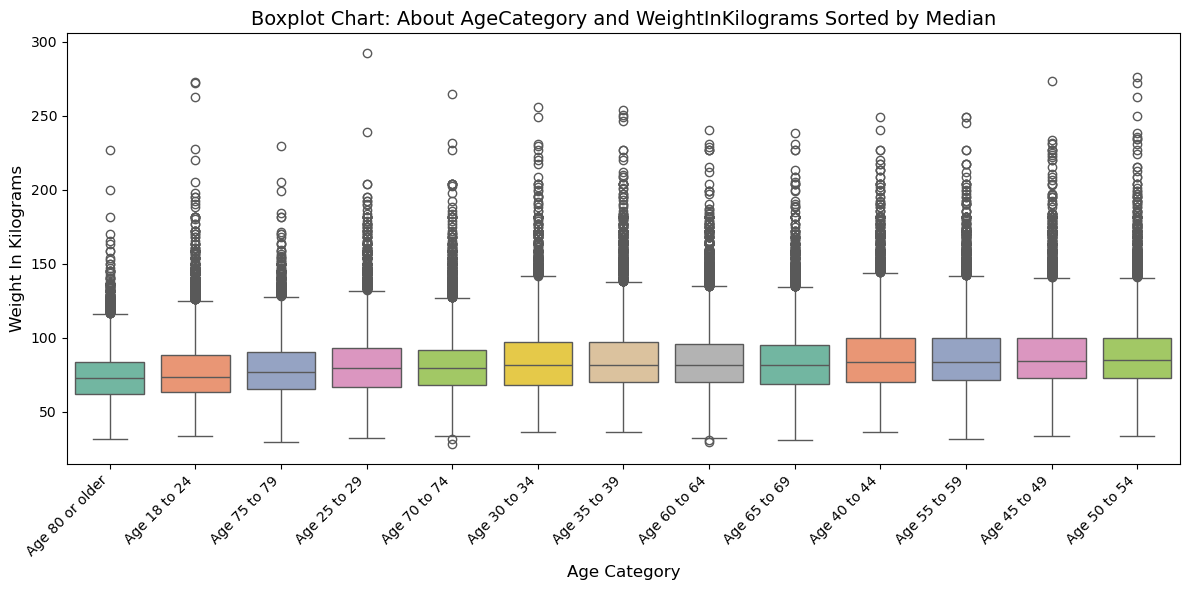

In [ ]:
country_order = DATA.groupby('AgeCategory')['WeightInKilograms'].median().sort_values().index
plt.figure(figsize=(12, 6))
sns.boxplot(x='AgeCategory', y='WeightInKilograms', data=DATA, order=country_order, palette='Set2')
plt.title("Boxplot Chart: About AgeCategory and WeightInKilograms Sorted by Median", fontsize=14)
plt.xlabel("Age Category", fontsize=12)
plt.ylabel("Weight In Kilograms", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

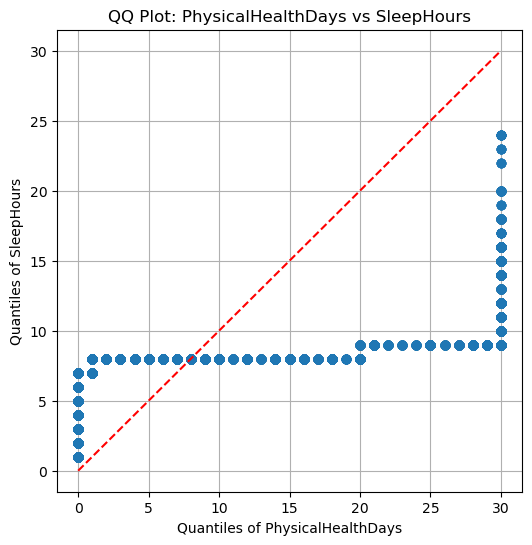

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# df = pd.read_csv("heart_disease_indicators.csv")

x = DATA['PhysicalHealthDays'].dropna()
y = DATA['SleepHours'].dropna()

min_len = min(len(x), len(y))
x = x.sample(min_len, random_state=1).sort_values().reset_index(drop=True)
y = y.sample(min_len, random_state=1).sort_values().reset_index(drop=True)

plt.figure(figsize=(6, 6))
plt.plot(x, y, 'o')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # đường 45 độ

plt.title('QQ Plot: PhysicalHealthDays vs SleepHours')
plt.xlabel('Quantiles of PhysicalHealthDays')
plt.ylabel('Quantiles of SleepHours')
plt.grid(True)
plt.show()


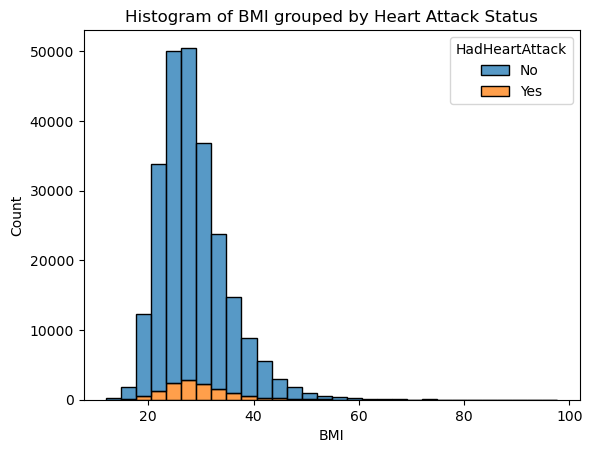

In [ ]:
import seaborn as sns

sns.histplot(data=DATA, x='BMI', hue='HadHeartAttack', multiple='stack', bins=30)
plt.title('Histogram of BMI grouped by Heart Attack Status')
plt.show()

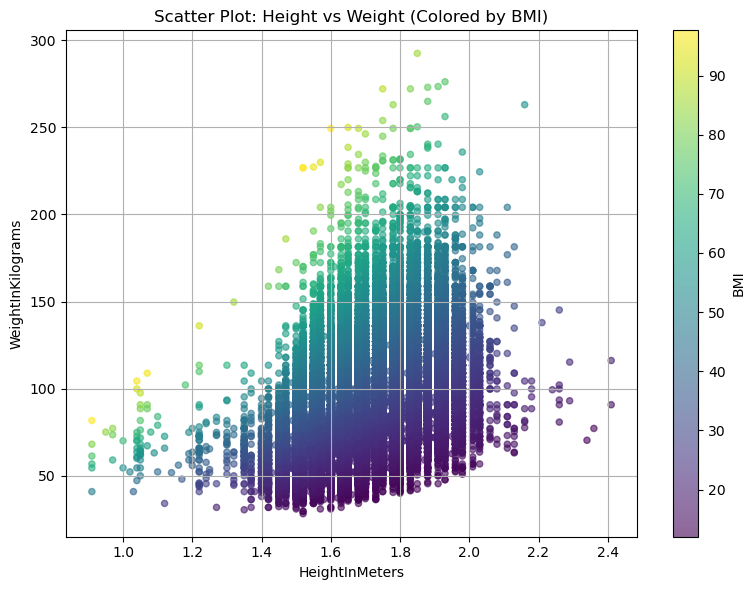

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(DATA['HeightInMeters'], DATA['WeightInKilograms'], c=DATA['BMI'], cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='BMI')  
plt.title('Scatter Plot: Height vs Weight (Colored by BMI)')
plt.xlabel('HeightInMeters')
plt.ylabel('WeightInKilograms')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\minhv\AppData\Local\Temp\ipykernel_24712\1160932912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='State', y='BMI', data=DATA, order=country_order, palette='Set2')


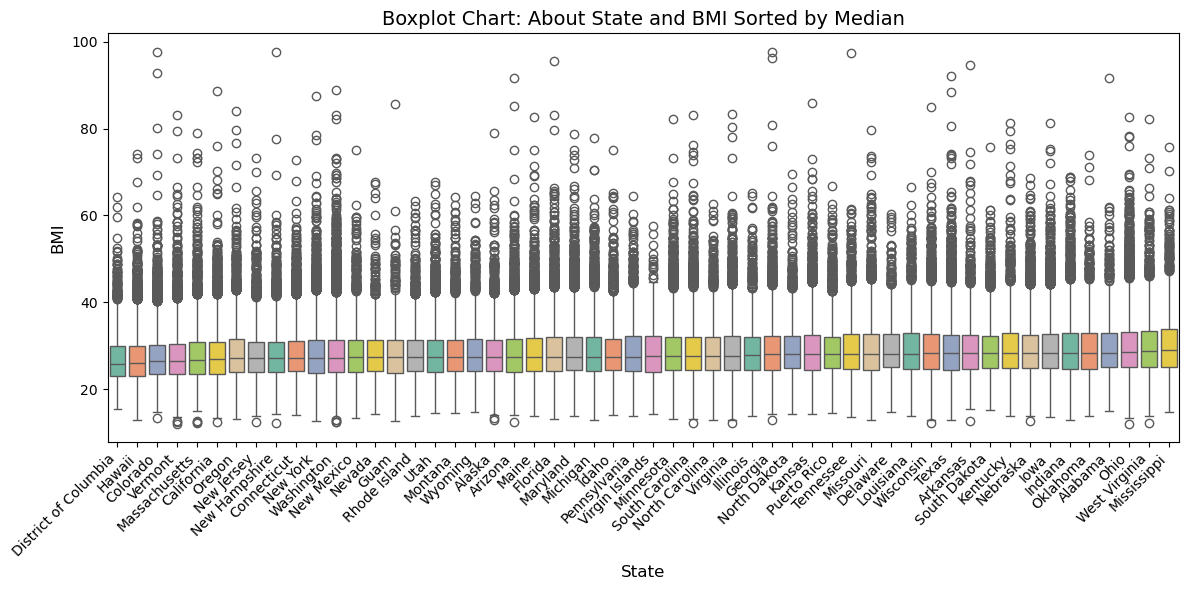

In [ ]:
country_order = DATA.groupby('State')['BMI'].median().sort_values().index
plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='BMI', data=DATA, order=country_order, palette='Set2')
plt.title("Boxplot Chart: About State and BMI Sorted by Median", fontsize=14)
plt.xlabel("State", fontsize=12)
plt.ylabel("BMI", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

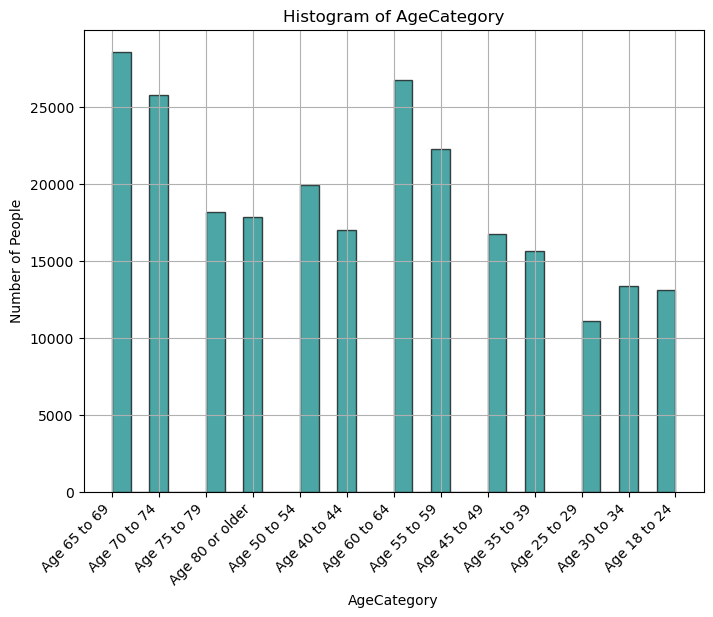

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(DATA['AgeCategory'].dropna(), bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.title('Histogram of AgeCategory')
plt.xlabel('AgeCategory')
plt.ylabel('Number of People')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

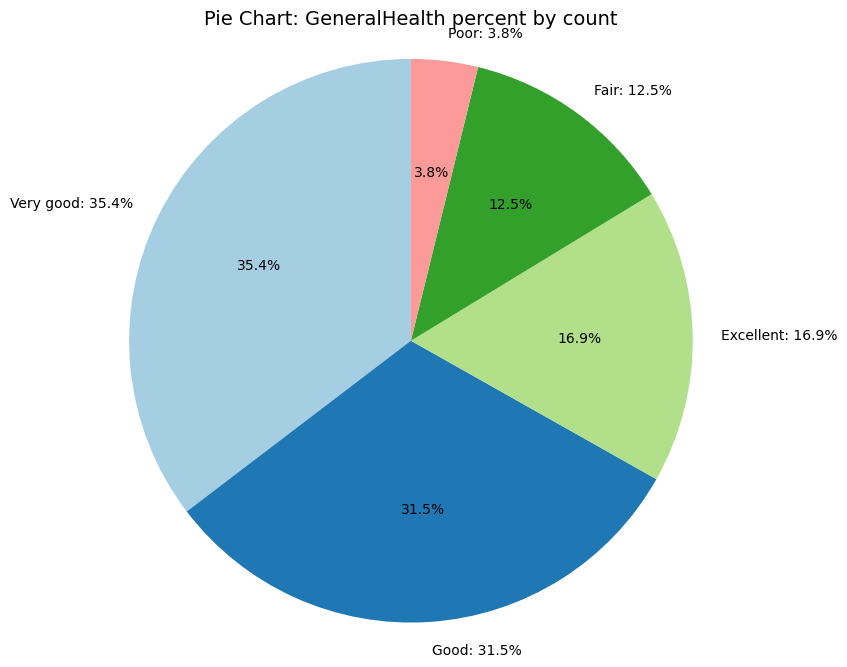

In [ ]:
df_grouped = DATA1['GeneralHealth'].value_counts().reset_index()
df_grouped.columns = ['GeneralHealth', 'count']
df_grouped['fraction'] = df_grouped['count'] / df_grouped['count'].sum()
df_grouped['percentage'] = round(df_grouped['fraction'] * 100, 1)
df_grouped['label'] = df_grouped['GeneralHealth'].map(reverse_GeneralHealth_mapping) + ": " + df_grouped['percentage'].astype(str) + "%"

plt.figure(figsize=(8, 8))
plt.pie(df_grouped['fraction'], labels=df_grouped['label'], autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Paired.colors)
plt.title("Pie Chart: GeneralHealth percent by count", fontsize=14)
plt.axis('equal')  
plt.show()


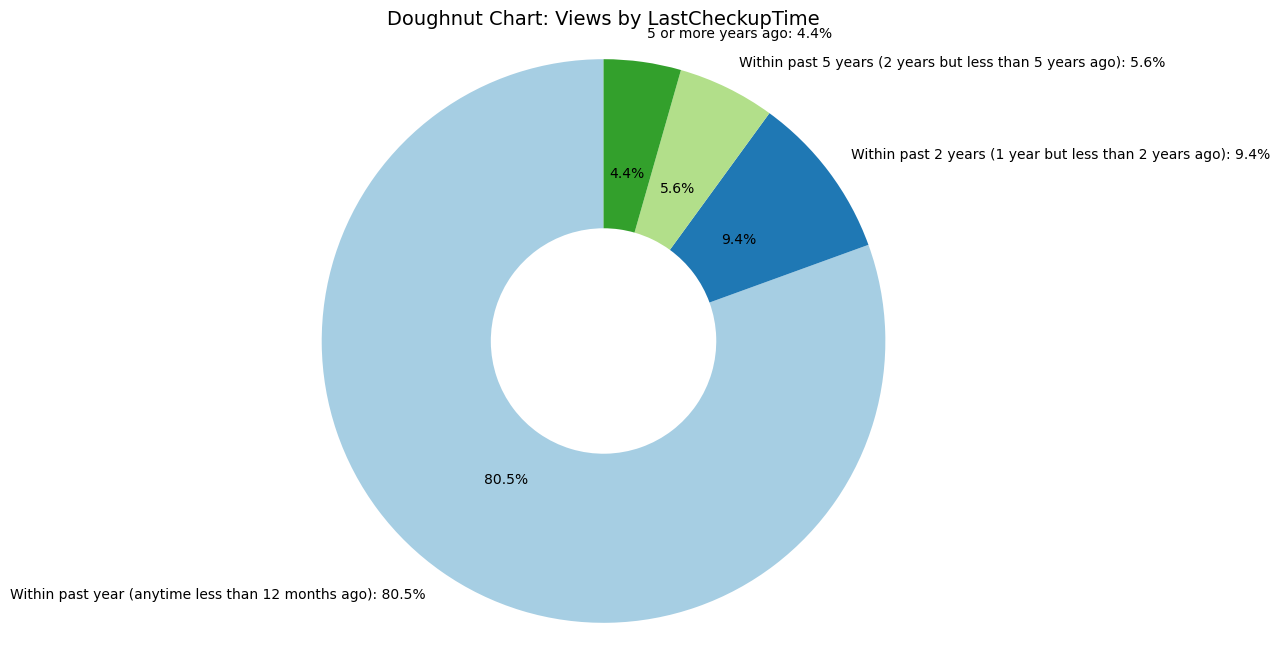

In [ ]:
df_grouped = DATA1['LastCheckupTime'].value_counts().reset_index()
df_grouped.columns = ['LastCheckupTime', 'count']
df_grouped['fraction'] = df_grouped['count'] / df_grouped['count'].sum()
df_grouped['percentage'] = round(df_grouped['fraction'] * 100, 1)
df_grouped['label'] = df_grouped['LastCheckupTime'].map(reverse_LastCheckupTime_mapping) + ": " + df_grouped['percentage'].astype(str) + "%"

plt.figure(figsize=(8, 8))
plt.pie(df_grouped['fraction'], labels=df_grouped['label'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, wedgeprops={'width': 0.6})
plt.title("Doughnut Chart: Views by LastCheckupTime", fontsize=14)
plt.axis('equal')
plt.show()

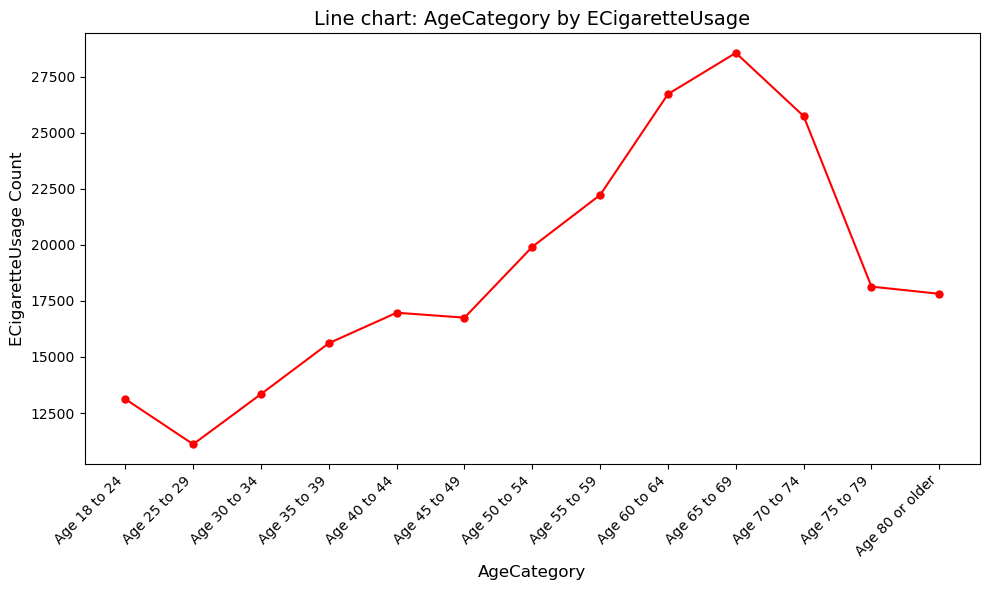

In [ ]:
df_grouped = DATA1.groupby('AgeCategory', as_index=False)['ECigaretteUsage'].count()
labels = [reverse_AgeCategory_mapping.get(x, str(x)) for x in df_grouped['AgeCategory']]
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['AgeCategory'], df_grouped['ECigaretteUsage'], color='red', marker='o', markersize=5)
plt.xticks(df_grouped['AgeCategory'], labels, rotation=45, ha='right')
plt.title("Line chart: AgeCategory by ECigaretteUsage", fontsize=14)
plt.xlabel("AgeCategory", fontsize=12)
plt.ylabel("ECigaretteUsage Count", fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\minhv\AppData\Local\Temp\ipykernel_24712\1129330356.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Sex', y='SmokerStatus', data=DATA1, palette='Set2')


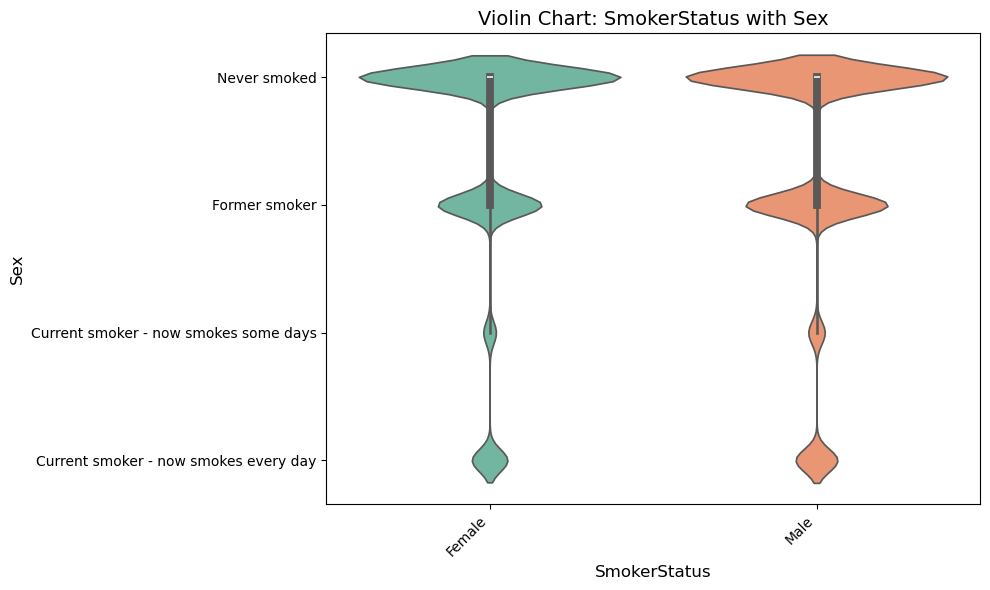

In [ ]:
df_grouped1 = DATA1.groupby('Sex', as_index=False)['SmokerStatus'].count()
labelx = [reverse_Sex_mapping.get(x, str(x)) for x in df_grouped1['Sex']]
df_grouped2 = DATA1.groupby('SmokerStatus', as_index=False)['Sex'].count()
labely = [reverse_SmokerStatus_mapping.get(x, str(x)) for x in df_grouped2['SmokerStatus']]
plt.figure(figsize=(10, 6))
sns.violinplot(x='Sex', y='SmokerStatus', data=DATA1, palette='Set2')
plt.title("Violin Chart: SmokerStatus with Sex", fontsize=14)
plt.xlabel("SmokerStatus", fontsize=12)
plt.ylabel("Sex", fontsize=12)
plt.xticks(df_grouped1['Sex'], labelx, rotation=45, ha='right')
plt.yticks(df_grouped2['SmokerStatus'], labely)
plt.tight_layout()
plt.show()

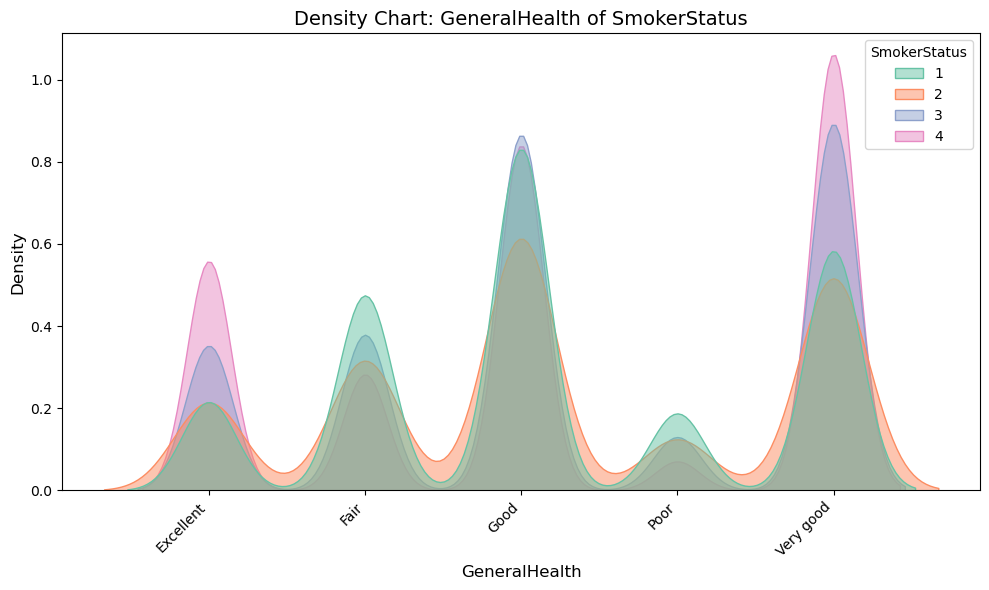

In [ ]:
df_grouped1 = DATA1.groupby('GeneralHealth', as_index=False)['SmokerStatus'].count()
labelx = [reverse_GeneralHealth_mapping.get(x, str(x)) for x in df_grouped1['GeneralHealth']]

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=DATA1,
    x='GeneralHealth',
    hue='SmokerStatus',
    common_norm=False,
    fill=True,
    alpha=0.5,
    palette='Set2'
)
plt.title("Density Chart: GeneralHealth of SmokerStatus", fontsize=14)
plt.xlabel("GeneralHealth", fontsize=12)
plt.xticks(df_grouped1['GeneralHealth'], labelx, rotation=45, ha='right')
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.show()

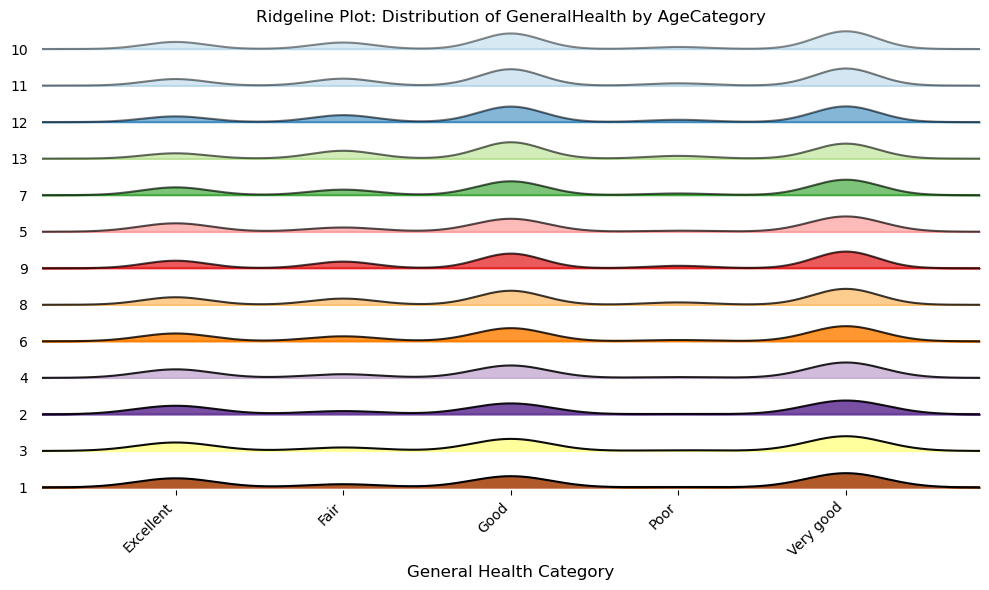

In [ ]:
data_grouped = [DATA1[DATA1['AgeCategory'] == day]['GeneralHealth'].dropna() for day in DATA1['AgeCategory'].unique()]
labels = list(DATA1['AgeCategory'].unique())

joyplot(
    pd.DataFrame(dict(zip(labels, data_grouped))),
    fade=True,
    figsize=(10, 6),
    title="Ridgeline Plot: Distribution of GeneralHealth by AgeCategory",
    colormap=plt.cm.Paired
)

xticks = list(GeneralHealth_mapping.values())  # [1, 2, 3, 4, 5]
xtick_labels = [reverse_GeneralHealth_mapping[i] for i in xticks]

plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45, ha='right')
plt.xlabel("General Health Category", fontsize=12)
plt.ylabel("Age Category", fontsize=12)
plt.tight_layout()
plt.show()


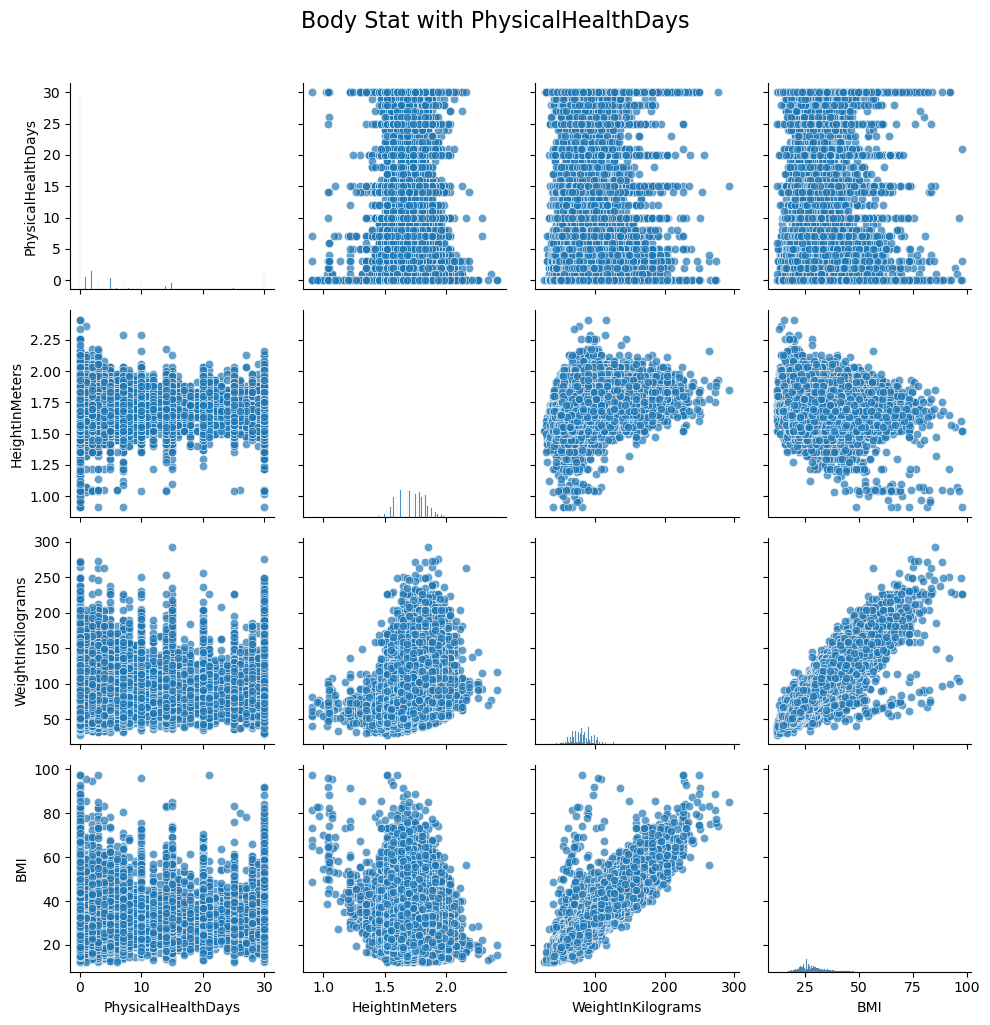

In [ ]:
data = DATA1[['PhysicalHealthDays', 'HeightInMeters', 'WeightInKilograms', 'BMI']]
sns.pairplot(data, kind='scatter', plot_kws={'alpha': 0.7}, diag_kind='hist', markers='o', hue=None, )
plt.suptitle("Body Stat with PhysicalHealthDays", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

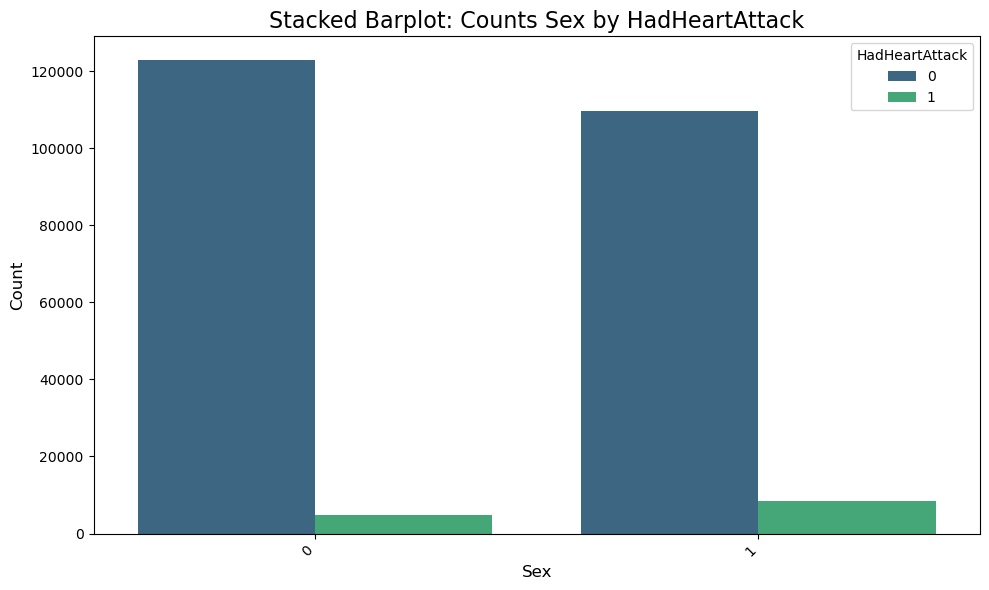

In [ ]:
data = (DATA1.groupby(['Sex', 'HadHeartAttack']).size().reset_index(name='count'))
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Sex', y='count', hue='HadHeartAttack', palette='viridis')
plt.title("Stacked Barplot: Counts Sex by HadHeartAttack", fontsize=16)
plt.xlabel("Sex", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="HadHeartAttack", loc="upper right")
plt.tight_layout()
plt.show()

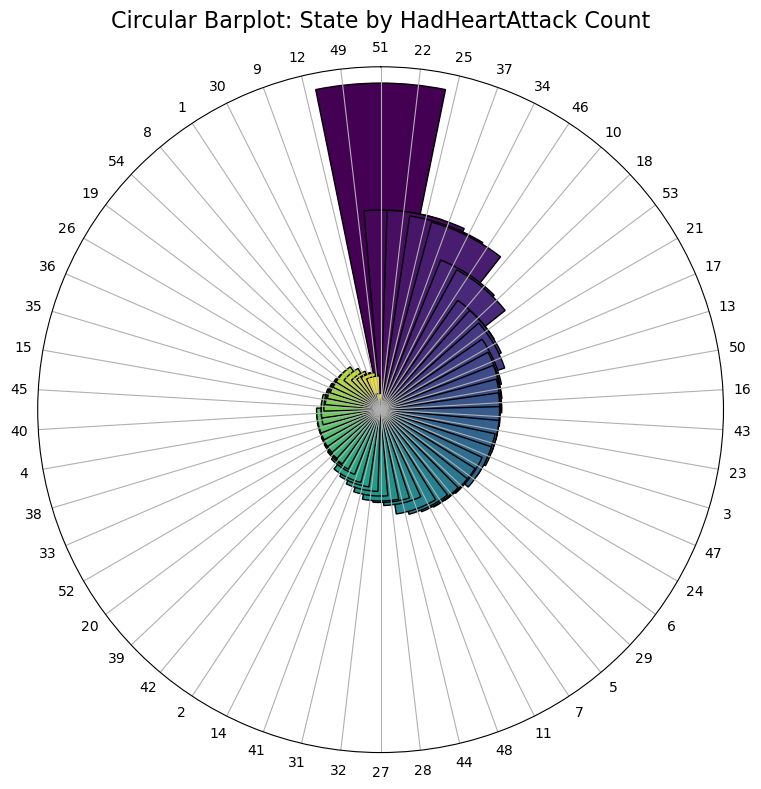

In [ ]:
data = (DATA1.groupby('State')['HadHeartAttack'].count().reset_index(name='cnt_HHA').sort_values(by='cnt_HHA', ascending=False))
data['State'] = pd.Categorical(data['State'], categories=data['State'], ordered=True)
angles = np.linspace(0, 2 * np.pi, len(data), endpoint=False)  
data['angle'] = angles 
colors = viridis(np.linspace(0, 1, len(data)))
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(data['angle'], data['cnt_HHA'], color=colors, edgecolor='black', width=0.4, align='center')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1) 
ax.set_xticks(data['angle'])
ax.set_xticklabels(data['State'])
ax.set_yticks([])  
ax.set_title("Circular Barplot: State by HadHeartAttack Count", va='bottom', fontsize=16)
plt.tight_layout()
plt.show()

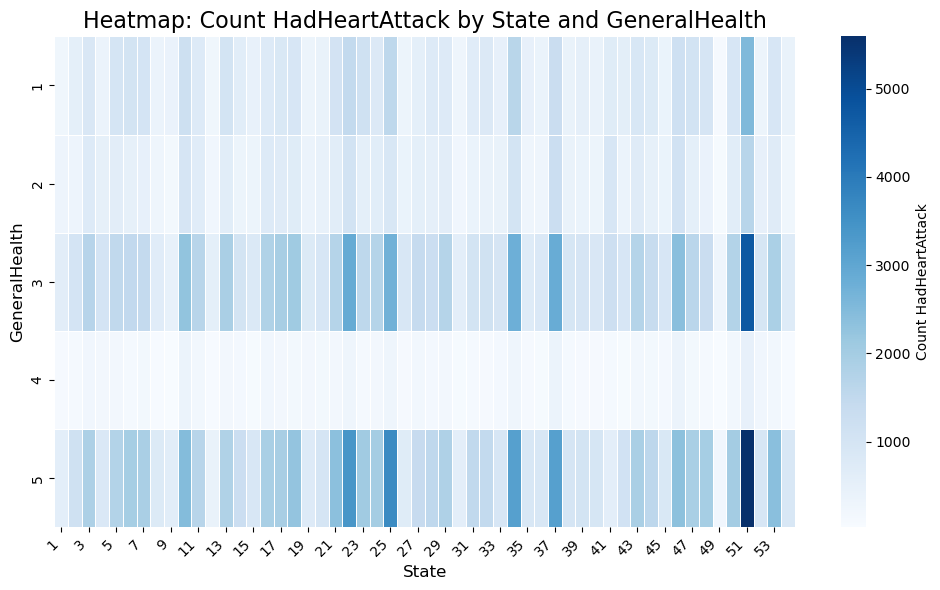

In [ ]:
data = (DATA1.groupby(['State', 'GeneralHealth'])['HadHeartAttack'].count().reset_index(name='total_HadHeartAttack'))
heatmap_data = data.pivot(index='GeneralHealth', columns='State', values='total_HadHeartAttack')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, fmt=".0f", cmap="Blues", linewidths=.5, cbar_kws={'label': 'Count HadHeartAttack'})
plt.title("Heatmap: Count HadHeartAttack by State and GeneralHealth", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("GeneralHealth", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
DATA1["SmokerStatus_Label"] = DATA1["SmokerStatus"].map(reverse_SmokerStatus_mapping)
data = (DATA1.groupby(['SmokerStatus_Label', 'AgeCategory'])['HadCOPD'].count().reset_index())
data.columns = ['SmokerStatus', 'AgeCategory', 'HadCOPD']

data['text'] = ("Smoker Status: " + data['SmokerStatus'].astype(str)+ "<br>Age Category: " + data['AgeCategory'].astype(str)+ "<br>Count: " + data['HadCOPD'].astype(str))

fig = px.scatter(
    data,
    x="AgeCategory",
    y="HadCOPD",
    size="HadCOPD",
    color="SmokerStatus",
    hover_name="SmokerStatus",
    hover_data={'text': True},
    title="Bubble Chart: COPD Cases by Smoker Status and Age Category",
    labels={"AgeCategory": "Age Category", "HadCOPD": "Number of Cases"},
    size_max=20,
    template="plotly_white"
)

fig.update_traces(marker=dict(opacity=0.7))
fig.update_xaxes(tickangle=45)
fig.update_layout(legend_title="Smoker Status")
fig.show()



In [ ]:
grouped = DATA1.groupby(['State', 'AgeCategory', 'GeneralHealth']).size().reset_index(name='Count')
fig = px.treemap(
    grouped,
    path=['State', 'AgeCategory', 'GeneralHealth'],
    values='Count',
    title='Tree Map of General Health by State and Age Category'
)
fig.show()
